In [1]:
import os
os.chdir('../../')

In [2]:
cd = os.getcwd()
functions_path = os.path.join(cd, '02_code/functions')

In [ ]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata as ad
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from anndata import AnnData
import skmisc
import regex as re
import scipy.stats as stats
from itertools import combinations

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

# from scipy.sparse import csr_matrix
import sys
sys.path.append(functions_path)
import functions_dat_processing as dp
import functions_plotting as dplt
import functions_OVA_annotation as oa

/tmp/ipykernel_598352/1512834465.py:19: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
#if needed, reload functions
import importlib
importlib.reload(dp)
importlib.reload(dplt)
importlib.reload(oa)

<module 'functions_OVA_annotation' from '/home/s377963/car_t_sc/02_code/functions/functions_OVA_annotation.py'>

First assess the quality of the hmmer aligned reads

In [5]:
path_to_hmmer = './01_data/processed/OVA_receptor/hmmersearch_alignment_outputs'
evals = oa.extract_evals_from_folder(path_to_hmmer)

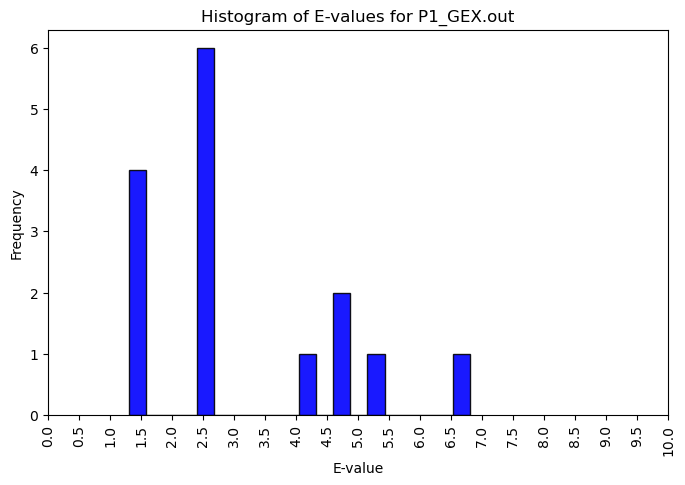

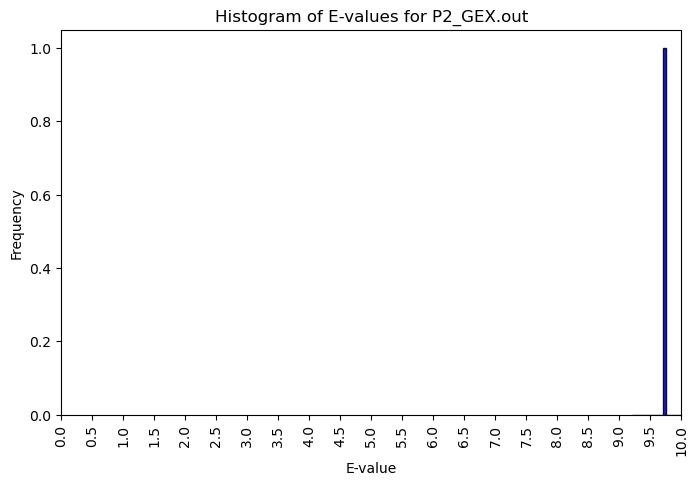

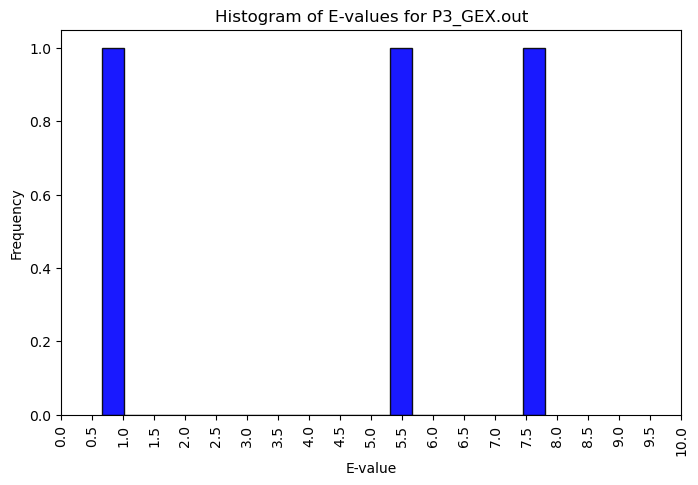

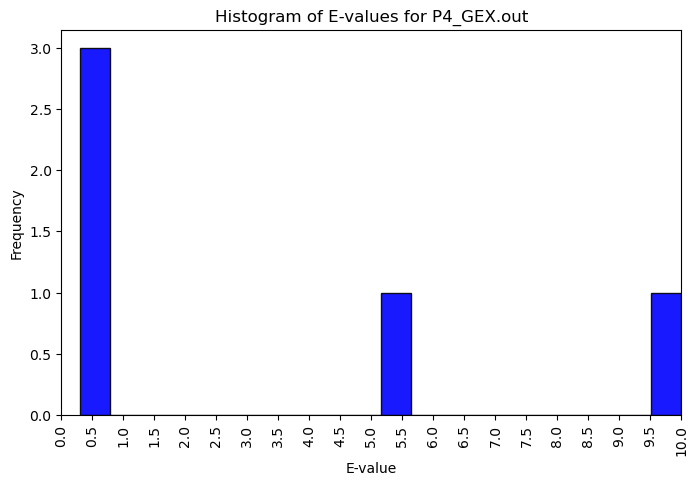

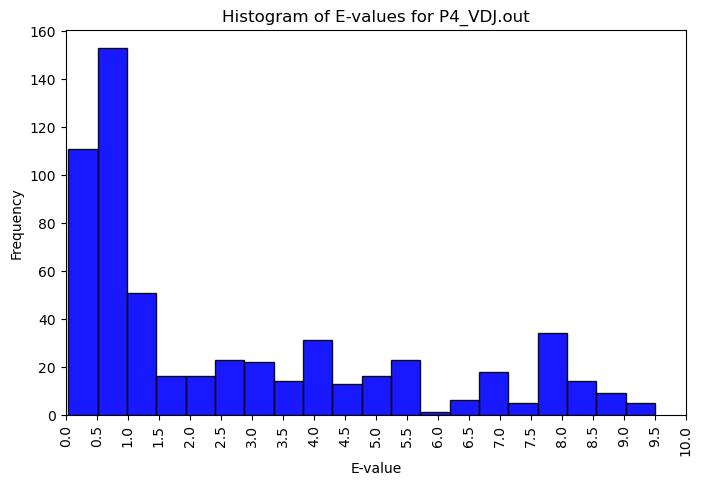

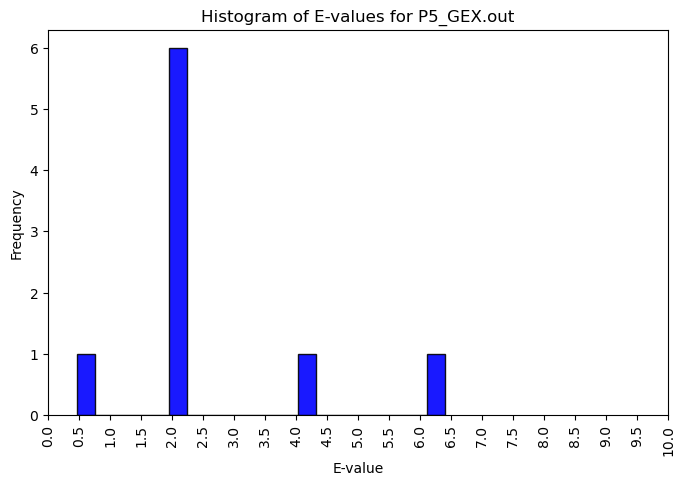

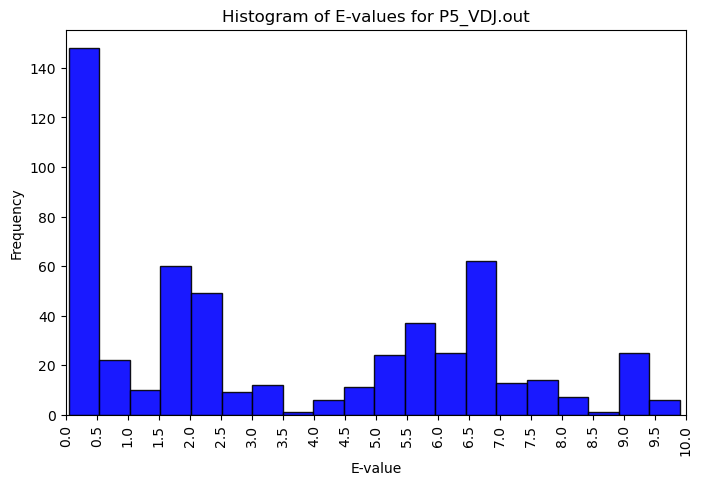

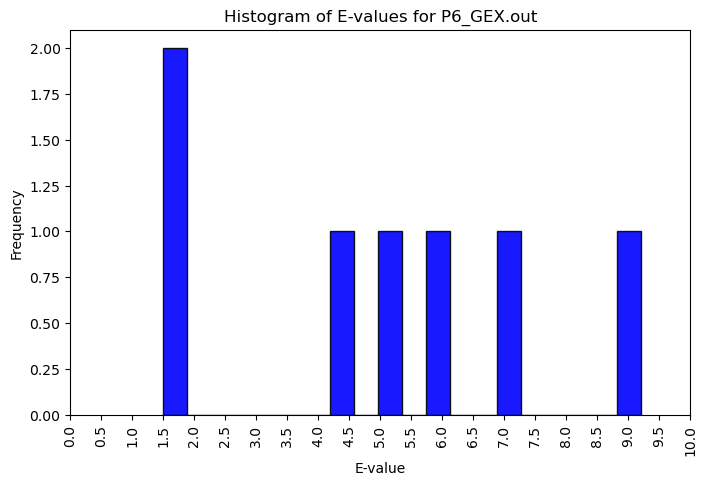

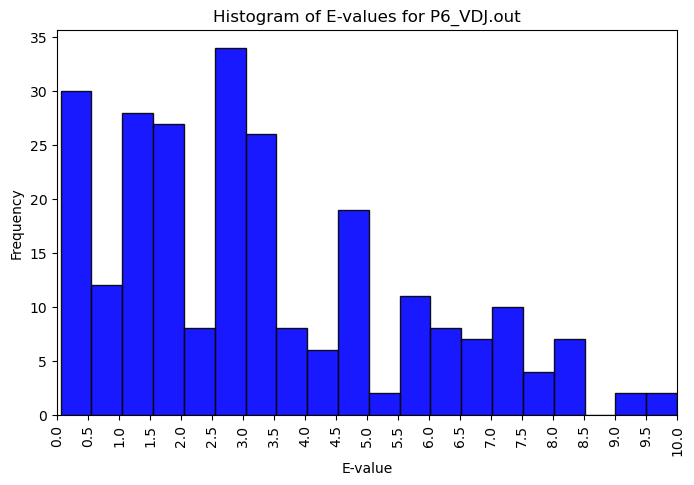

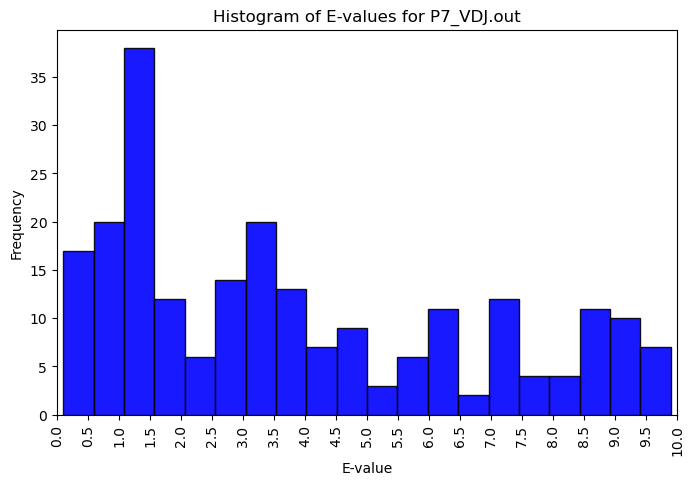

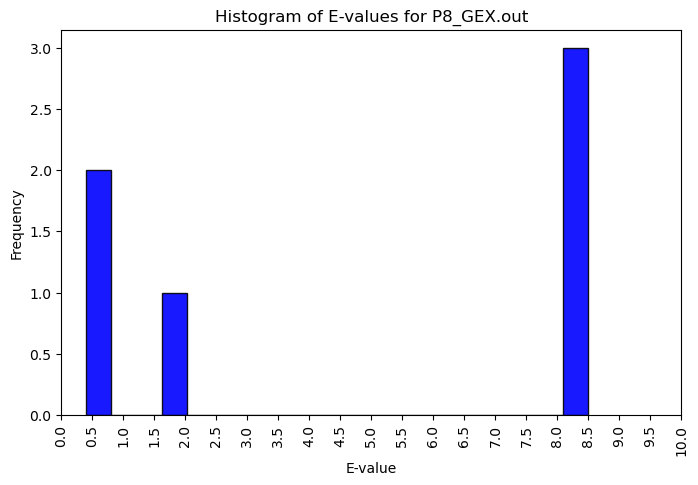

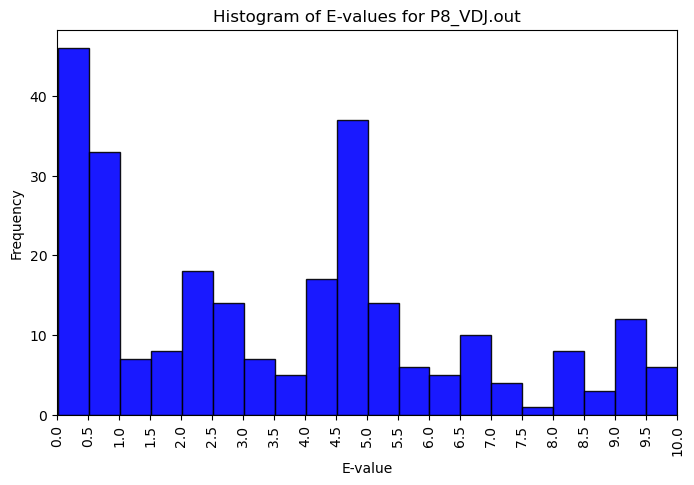

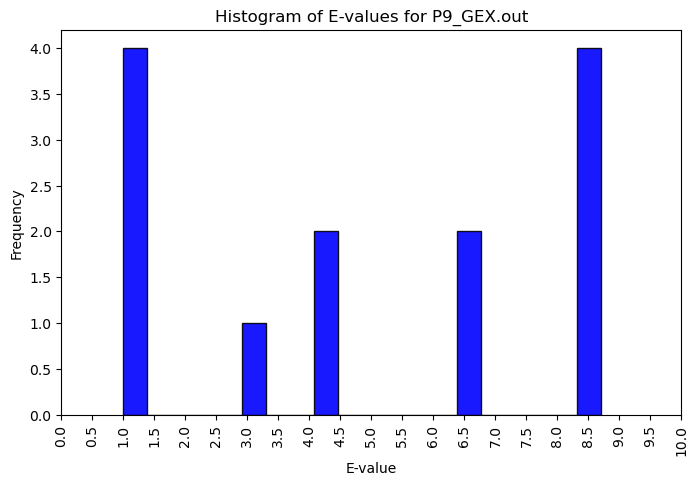

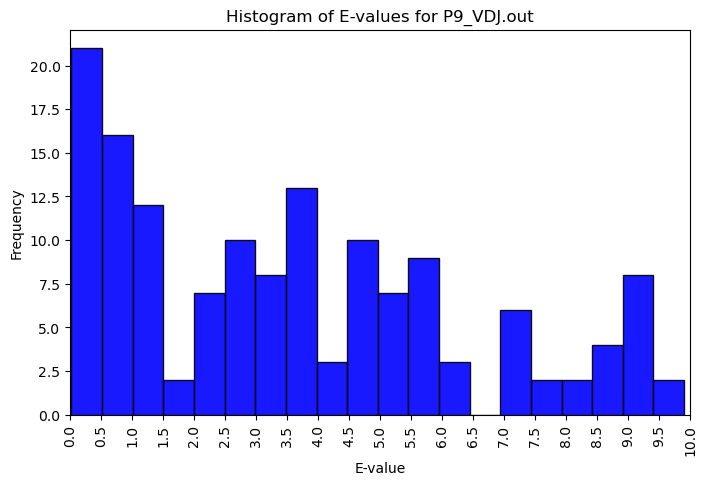

In [6]:
# Create a histogram for each key (file) in pool_evals
for key, evalues in evals.items():
    if not evalues:  # Skip empty lists
        continue
    evalues = np.asarray(evalues)
    plt.figure(figsize=(8, 5))  # Create a new figure for each histogram
    plt.hist(evalues, bins=20, color='blue', alpha=0.9, edgecolor='black')  # Histogram settings
    # plt.yscale('log')  # Log scale for better visibility if values vary widely
    plt.xlabel('E-value')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of E-values for {key}')
    # plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=90)
    plt.xlim(0, 10)
    plt.xticks(np.arange(0, 10.5, 0.5))
    
    # Show or save the histogram
    plt.show() 

Import data

In [4]:
path_to_folders = './01_data/raw/cellranger_multi'
path_to_raw_count_matrices_in_folders = 'count/raw_feature_bc_matrix'

adatas_really_raw_list = dp.read_all_pools(path_to_folders, path_to_raw_count_matrices_in_folders)

for i,adata in enumerate(adatas_really_raw_list):
    adata.obs['dataset'] = i

adata_really_raw = ad.concat(adatas_really_raw_list, join='inner') 

Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P1_cellranger/count/raw_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P2_cellranger/count/raw_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P3_cellranger/count/raw_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P4_cellranger/count/raw_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P5_cellranger/count/raw_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P6_cellranger/count/raw_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P7_cellranger/count/raw_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P8_cellranger/count/raw_feature_bc_matrix
Reading from: ./01_data/raw/cellranger_multi/2024-06-07_24054SC_Luu_P9_cellranger/count/raw_feature_bc_matrix
Read a tot

/home/s377963/mambaforge/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
#import data
adata_raw = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_raw_demultiplexed.h5ad') 
adata_qc = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc.h5ad')
adata_TIL_only = adata_qc[adata_qc.obs.Location != 'dLN']
adata_pureTC = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation.h5ad') 
adata_only_pureTC = adata_pureTC[adata_pureTC.obs['is.pure_Tcell'] == 'Pure']
adata_pure_TC_annotated = sc.read_h5ad('./01_data/processed/merged_and_processed/XXXCAR_genome/XXXCAR_genome_after_qc_TIL_only_pure_TC_annotation_non_TC_filtered_TC_subtypes_annotated.h5ad') 
adata_only_annotatedTC = adata_pure_TC_annotated[~adata_pure_TC_annotated.obs['functional.cluster'].isna()]

In [6]:
non_annotated = [adata_raw, adata_TIL_only, adata_only_pureTC, adata_only_annotatedTC]

In [148]:
adata_raw = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_pools_prior_any_processing.h5ad') #prior to any sort of processing, shows maximal possible yield with respect to CAR-T annotation
adata_dLN = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_calagry_exact_TIL_only.h5ad') #after dLN filtering
adata_pureTC = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_pureTCs_calagry_exact.h5ad') #after annotating pureTCs and prior to anotating TC subtypes
adata_pure_TC_and_rest = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_calagry_exact_TIL_only_celltypes.h5ad') #after annotating pureTCs and prior to anotating TC subtypes
adata_annotated = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_scaled_pureTCs_annotated_calagry_exact.h5ad') #after annotating TCs and TC subtypes

# differently processed datasets
# adata = sc.read_h5ad('/home/s377963/car_t_sc/01_data/processed/merged_and_processed/merged_1xintegrated_scaled_pureTCs_annotated_pseudocount.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_abs_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_mad_soupx_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/hashsolo_mad_integrated_hvg_TCannotated_TCsubtypes.h5ad')
# adata = sc.read('./01_data/processed/merged_and_processed/HTODemux_abs_1000_nosoup.h5ad')

In [7]:
for adata in non_annotated:
    adata.obs.rename(columns={"HTO_classification": "Classification"}, inplace=True) 
    adata.obs.rename(columns={"functional.cluster": "Tcell_subtype"}, inplace=True)
    adata.obs.rename(columns={"pool": "dataset"}, inplace=True)
    rmvd_p = [int(dataset.replace("P", "")) - 1 for dataset in adata.obs['dataset']]
    adata.obs['dataset'] = rmvd_p

/tmp/ipykernel_598352/939101785.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['dataset'] = rmvd_p


In [8]:
#import corrected barcodes and process
path = './01_data/processed/cellbarcode_correction/unq_barcodes'
correction_dfs = oa.read_cellbarcode_tsvs(path)

In [9]:
#import OVA counts from VDJ and GEX library and process
path = './01_data/processed/OVA_receptor/OVA_counts'
VDJ_GEX_list = oa.read_and_merge_annotation(path) #list with dims: list[1][8]
merged = [oa.merge_VDJ_and_GEX(GEX, VDJ) for (GEX, VDJ) in zip(*VDJ_GEX_list)]

In [10]:
#correct the barcodes for the OVA count dataframes
merged_corrected = [oa.merge_OVA_counts_with_corrected_cellbarcodes(brcd, car_counts) for brcd, car_counts in zip(correction_dfs, merged)]

# Check how many cells are actually annotated

In [16]:
importlib.reload(oa)
OVA_genes = ['TCRa', 'TCRb']
new_adata = oa.annotate_mapped_OVA(adata_really_raw, merged)
new_adata.obs[OVA_genes] = new_adata.obs[OVA_genes].fillna(0)

OVA_genes = ['TCRa', 'TCRb']
new_adata2 = oa.annotate_mapped_OVA(adata_really_raw, merged_corrected)
new_adata2.obs[OVA_genes] = new_adata2.obs[OVA_genes].fillna(0)

/home/s377963/mambaforge/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/s377963/mambaforge/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [21]:
print(oa.isOVA(new_adata))
print(sum([len(m) for m in merged]))

View of AnnData object with n_obs × n_vars = 494 × 33699
    obs: 'dataset', 'TCRb', 'TCRa'
645


In [22]:
print(oa.isOVA(new_adata2))
print(sum([len(m) for m in merged_corrected]))

View of AnnData object with n_obs × n_vars = 521 × 33699
    obs: 'dataset', 'TCRb', 'TCRa'
521


In [ ]:
merged_df = pd.concat(merged_corrected, ignore_index=True)
merged_df = pd.concat(merged, ignore_index=True)
merged_df["Cellbarcode"].to_csv("/home/s377963/car_t_sc/01_data/processed/cellbarcode_correction/unq_barcodes/merged_raw.txt", index=False, header=False)

# Plot the OVA TCR counts for each condition at each day, test for differences

In [12]:
#annotate the OVA counts via the corrected OVA counts to the original anndata object
OVA_genes = ['TCRa', 'TCRb']
annotated = []
for adata in non_annotated:
    new_adata = oa.annotate_mapped_OVA(adata, merged)
    new_adata.obs[OVA_genes] = new_adata.obs[OVA_genes].fillna(0)
    annotated.append(new_adata)

In [104]:
importlib.reload(oa)
cols = ['TCRa_only', 'TCRb_only', 'TCRb_TCRa', 'None']
to_extract = ['condition', 'day', 'TCRa', 'TCRb']
df = oa.extract_receptor_count(annotated[2], to_extract, cols, 2)

df_rel = df.copy()
df_rel[cols] = df[cols].div(df['Total'], axis=0) * 100

/home/s377963/car_t_sc/02_code/functions/functions_OVA_annotation.py:137: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = df.groupby(groups)[colnames].sum()


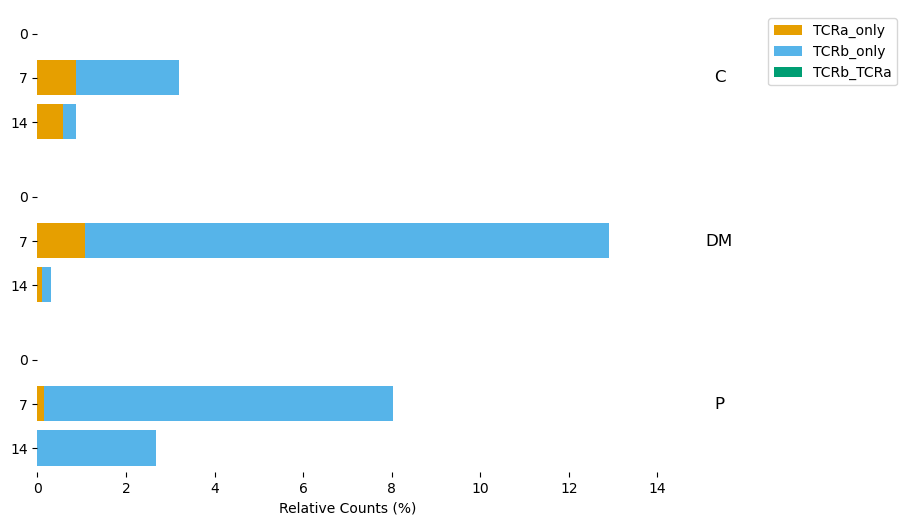

In [29]:
importlib.reload(oa)
oa.plot_receptor_counth(df_rel, grouping='condition', hue='day', xmax=14, counts='Relative Counts (%)')

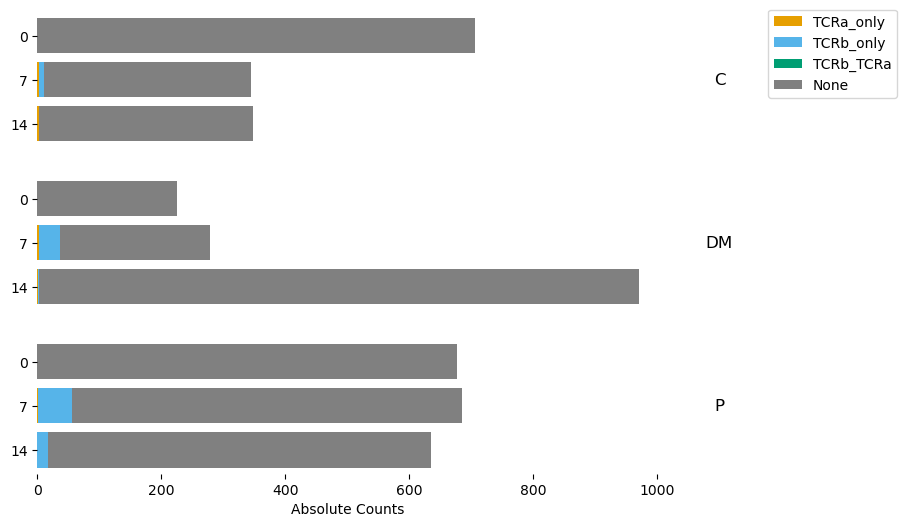

In [30]:
importlib.reload(oa)
oa.plot_receptor_counth(df, grouping='condition', xmax = 1000, hue='day', label=slice(2,6))

# perform a statistical test in order to see differences between conditions and days

In [ ]:
oa.extract_replicate(annotated[2], 'Classification')
cols = ['TCRa_only', 'TCRb_only', 'TCRb_TCRa', 'None']
to_extract = ['condition', 'day', 'replicate', 'TCRa', 'TCRb']
df = oa.extract_receptor_count(annotated[2], to_extract, cols, 3)

df_rel = df.copy()
df_rel[cols] = df[cols].div(df['Total'], axis=0) * 100
df_rel[cols] = df_rel[cols].fillna(0)
df_rel['total_tcr'] = df_rel[['TCRa_only', 'TCRb_only', 'TCRb_TCRa']].sum(axis=1)

/home/s377963/car_t_sc/02_code/functions/functions_OVA_annotation.py:137: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = df.groupby(groups)[colnames].sum()


In [98]:
df_rel[['condition', 'day', 'replicate', 'total_tcr']]

,condition,day,replicate,total_tcr
0,C,0,1,0.000000
1,C,0,2,0.000000
2,C,0,3,0.000000
3,C,0,4,0.000000
4,C,7,1,0.000000
5,C,7,2,0.000000
6,C,7,3,0.000000
7,C,7,4,14.285714
8,C,14,1,0.000000
9,C,14,2,1.369863


### DO ANOVA

In [101]:
# Perform ANOVA for each day
for day in df_rel["day"].unique():
    subset = df_rel[df_rel["day"] == day]  # Filter data for a specific day

    # Group data by condition
    grouped_data = [group["total_tcr"].values for _, group in subset.groupby("condition")]

    # Ensure all groups have replicates before testing
    if all(len(group) > 1 for group in grouped_data):
        f_stat, p_value = stats.f_oneway(*grouped_data)
        print(f"Day {day}: ANOVA F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")
    else:
        print(f"Day {day}: Not enough replicates for statistical testing.")

Day 0: ANOVA F-statistic = nan, p-value = nan
Day 7: ANOVA F-statistic = 2.5973, p-value = 0.1287
Day 14: ANOVA F-statistic = 2.8110, p-value = 0.1126


/tmp/ipykernel_598352/823838800.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = [group["total_tcr"].values for _, group in subset.groupby("condition")]
/home/s377963/mambaforge/envs/scanpy/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


### Do pairwise t.test

In [ ]:
for day in df_rel["day"].unique():
    subset = df_rel[df_rel["day"] == day]
    conditions = subset["condition"].unique()

    print(f"\nDay {day} - Pairwise t-tests:")
    for cond1, cond2 in combinations(conditions, 2):
        group1 = subset[subset["condition"] == cond1]["total_tcr"]
        group2 = subset[subset["condition"] == cond2]["total_tcr"]

        if len(group1) > 1 and len(group2) > 1:  # Ensure sufficient replicates
            t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
            print(f"  {cond1} vs {cond2}: t={t_stat:.4f}, p={p_val:.4f}")



Day 0 - Pairwise t-tests:
  C vs DM: t=nan, p=nan
  C vs P: t=nan, p=nan
  DM vs P: t=nan, p=nan

Day 7 - Pairwise t-tests:
  C vs DM: t=-2.3565, p=0.0741
  C vs P: t=-0.0835, p=0.9362
  DM vs P: t=2.0310, p=0.1120

Day 14 - Pairwise t-tests:
  C vs DM: t=-0.1405, p=0.8929
  C vs P: t=-2.1205, p=0.0782
  DM vs P: t=-1.9774, p=0.0954


# Plot the absolute OVA TCR counts for each pool 

In [16]:
list_of_dfs = []
dataset_names = ['Raw', 'QC', 'TC', 'TC-S']
cols = ['TCRa_only', 'TCRb_only', 'both', 'None']
to_extract = ['dataset', 'TCRa', 'TCRb']


for i,adata in enumerate(annotated):
    categories_df = oa.extract_receptor_count(adata, to_extract, cols)
    categories_df.insert(0, 'Dataset', f'{dataset_names[i]}')  # Insert 'Dataset' as the first column
    categories_df['dataset'] = categories_df['dataset'] + 1
    list_of_dfs.append(categories_df)
merged_dfs = pd.concat(list_of_dfs, ignore_index=True)


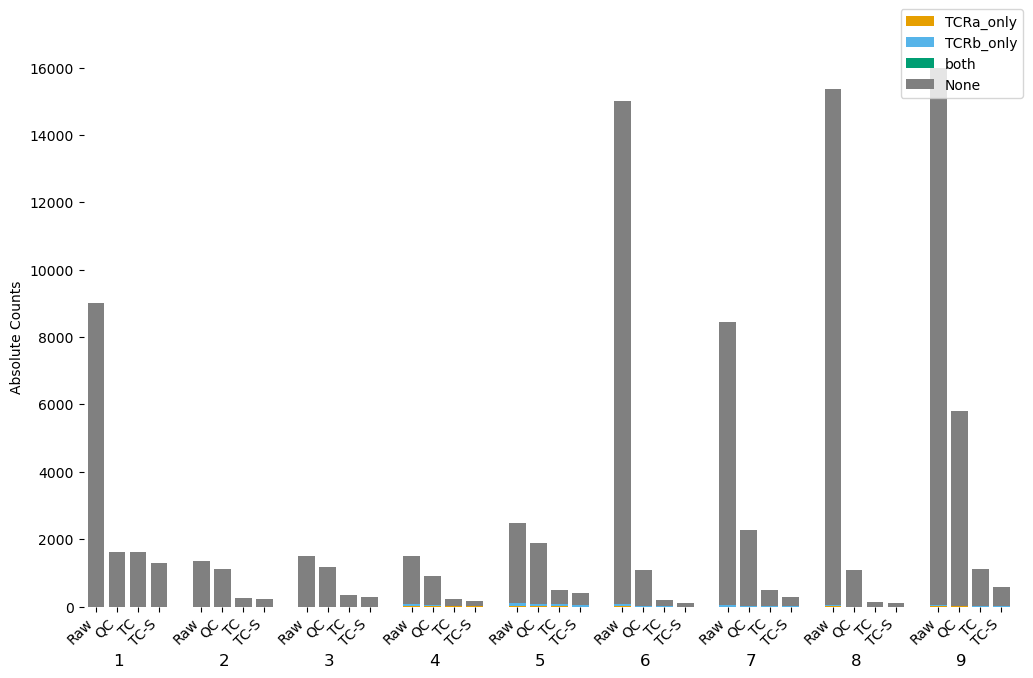

In [18]:
importlib.reload(oa)
oa.plot_receptor_countv(merged_dfs, grouping='dataset', hue='Dataset', ymax=16000, figrsize = (12,7), label = slice(2,6))

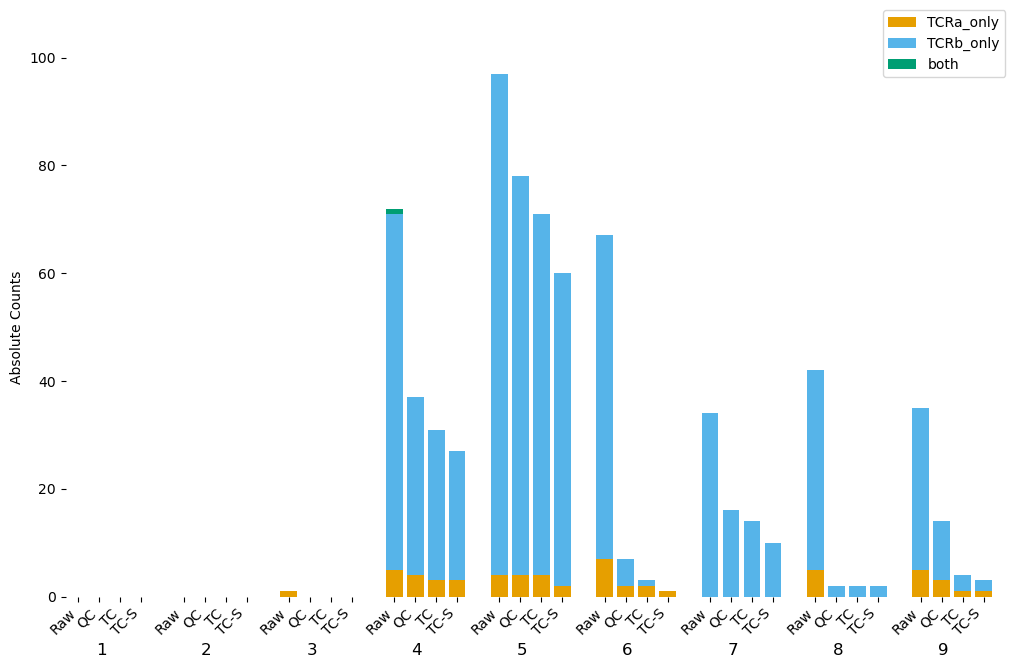

In [21]:
oa.plot_receptor_countv(merged_dfs, grouping='dataset', hue='Dataset', ymax=100, figrsize = (12,7), label = slice(2,5))

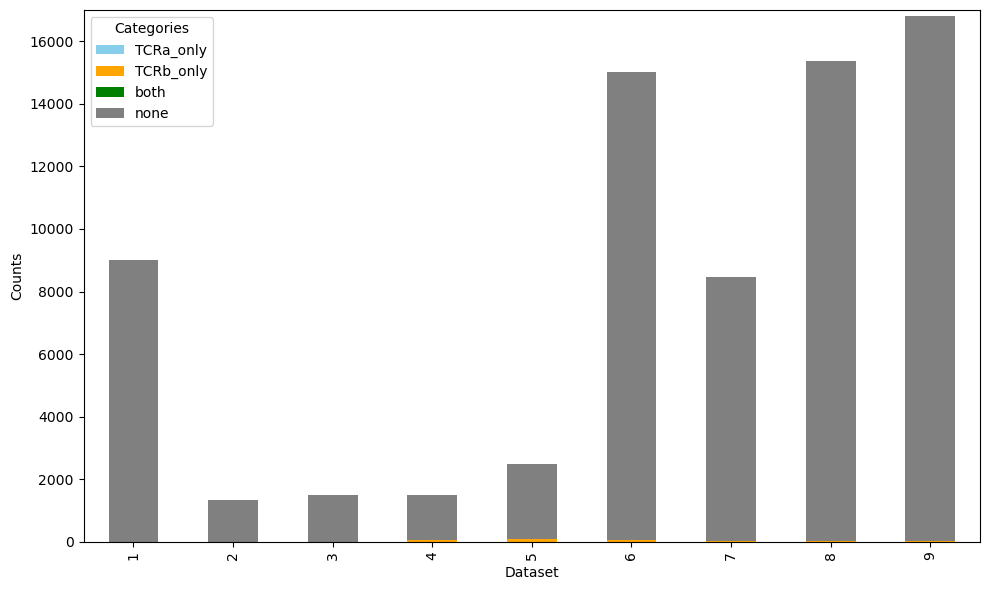

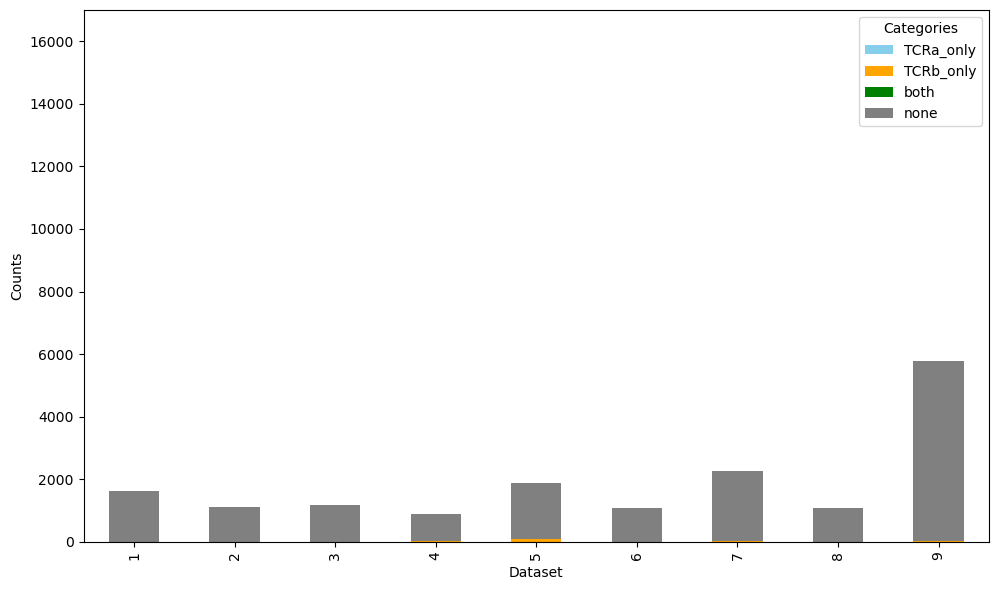

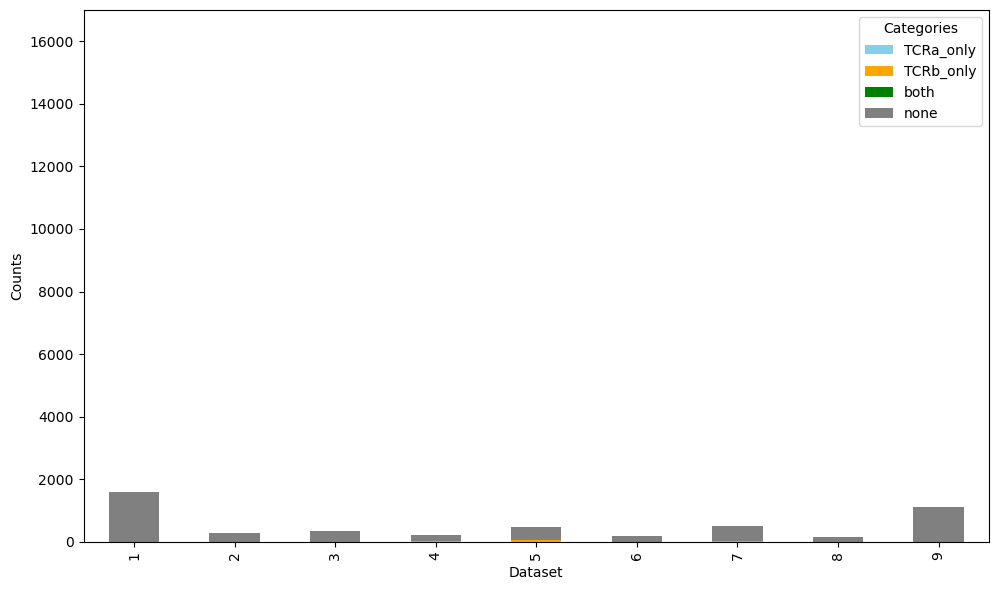

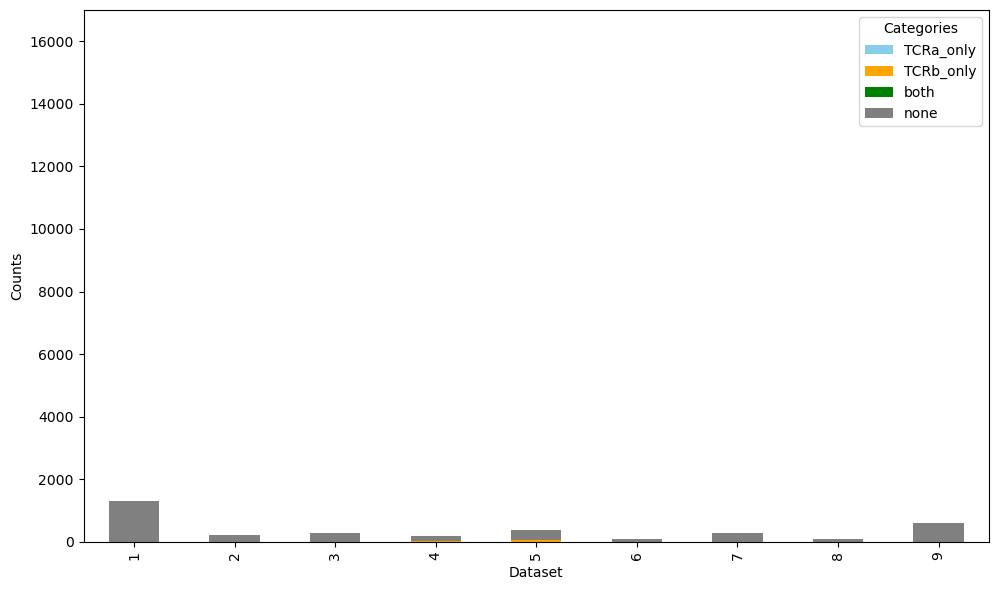

In [ ]:
for i,adata in enumerate(annotated):
    datasets = np.unique(adata.obs.dataset)

    # Calculate the categories
    categories_df = oa.calculate_categories(adata.obs, datasets)

    # Plot the stacked bar plot
    ax = categories_df.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=['skyblue', 'orange', 'green', 'gray'])
    # plt.title('Stacked Bar Plot of CD19_trunc and R11_ScFV Categories')
    plt.xlabel('Dataset')
    plt.ylabel('Counts')
    plt.legend(title='Categories')
    plt.tight_layout()
    plt.ylim(0, 17000)
    plt.show()

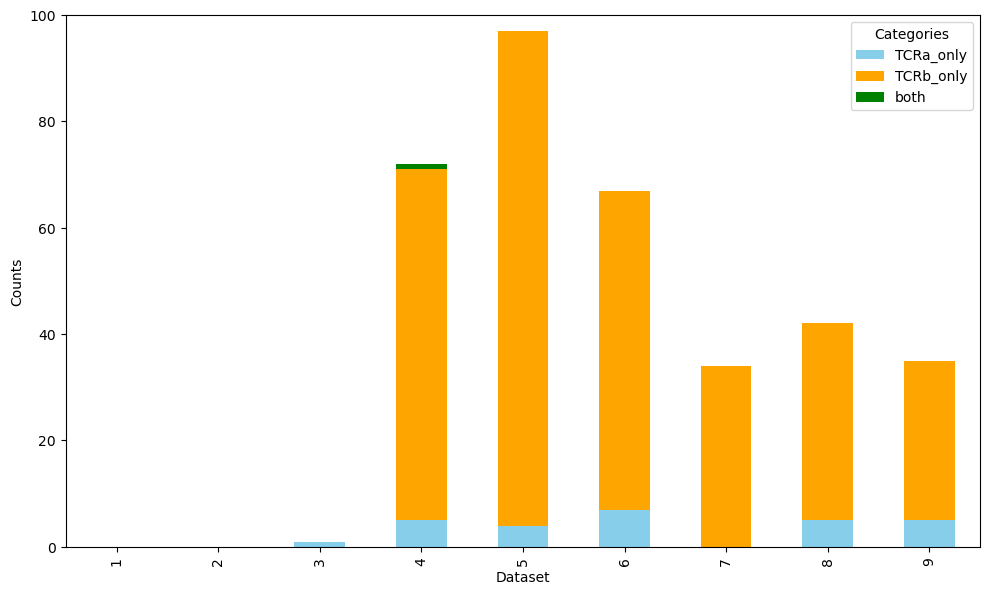

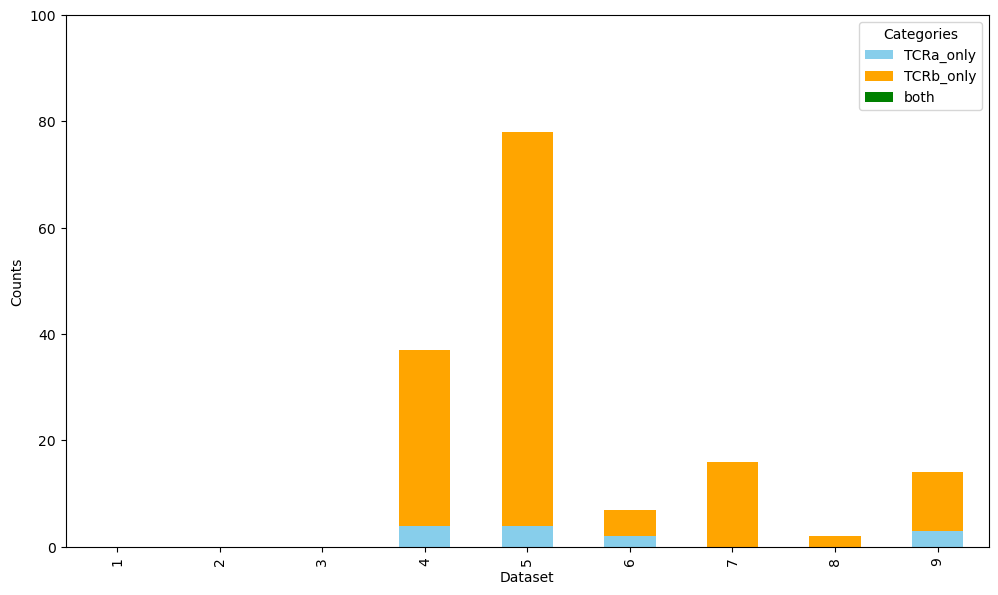

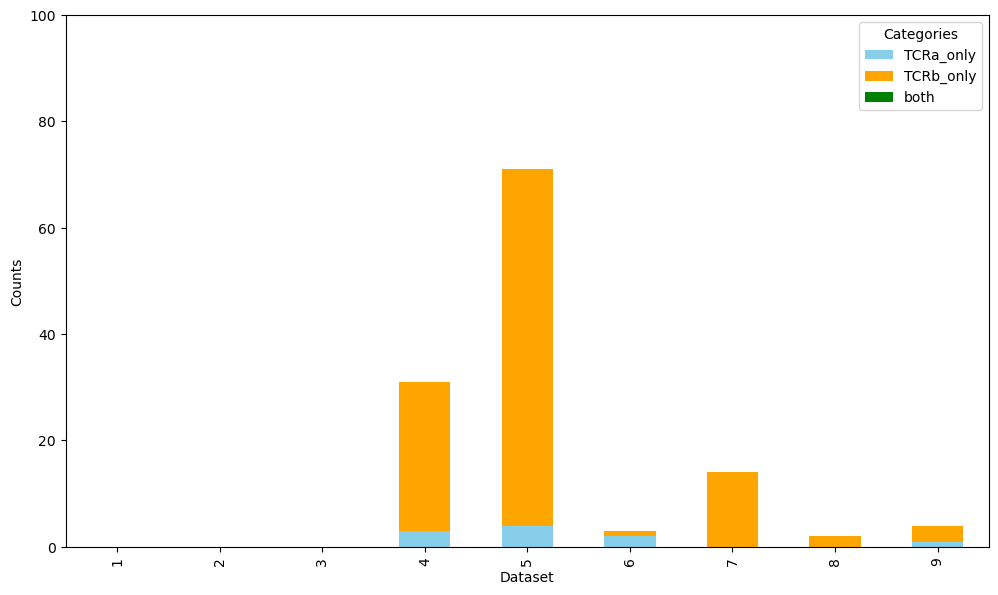

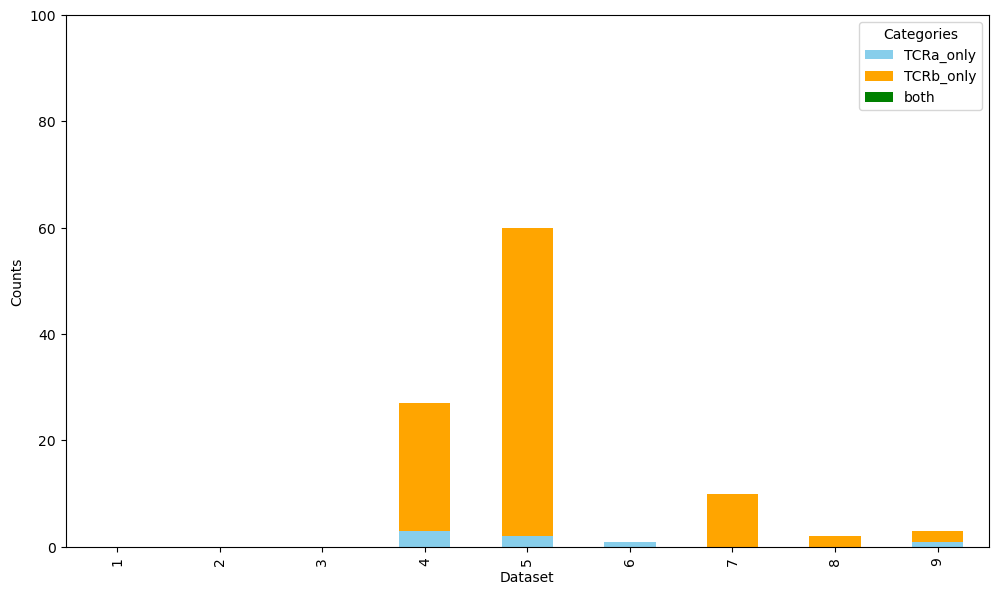

In [23]:
for i,adata in enumerate(annotated):
    datasets = np.unique(adata.obs.dataset)
    # datasets = list(filter(lambda x: x != 0, datasets))

    # Calculate the categories
    categories_df = oa.calculate_categories(adata.obs, datasets)
    categories_df.drop(columns=['none'], inplace=True)
    # Plot the stacked bar plot
    ax = categories_df.plot(kind='bar', stacked=True, figsize=(10, 6), 
                            color=['skyblue', 'orange', 'green', 'gray'])
    # plt.title(f'')
    plt.xlabel('Dataset')
    plt.ylabel('Counts')
    plt.legend(title='Categories')
    plt.tight_layout()
    plt.ylim(0, 100)
    plt.show()

In [15]:
#check what celltypes OVA TCR containing cells are assigned to if not pure TCs
tcs_only_and_ova_annotated = annotated[2]
only_ova = oa.isOVA(tcs_only_and_ova_annotated)
only_ova_nonTCs = only_ova[only_ova.obs['is.pure_Tcell'] == 'Impure']

In [15]:
pd.unique(annotated[1].obs.Classification)

# annotated[1].obs.Classification == 'd0P'

['d0-P', 'd0-DM', 'd0-C', 'd7-C2-TIL', 'd7-C1-TIL', ..., 'd14-DM1-TIL', 'd14-DM2-TIL', 'd14-DM4-TIL', 'd14-P4-TIL', 'd14-C4-TIL']
Length: 27
Categories (27, object): ['d0-C', 'd0-DM', 'd0-P', 'd7-C1-TIL', ..., 'd14-P1-TIL', 'd14-P2-TIL', 'd14-P3-TIL', 'd14-P4-TIL']

In [22]:
annotated[1].obs

,nCount_RNA,nFeature_RNA,nCount_HTO,nFeature_HTO,HTO_maxID,HTO_secondID,HTO_margin,Classification,hash.ID,percent.mt,...,G2M.Score,Phase,RNA_snn_res.0.5,seurat_clusters,dataset,condition,day,Location,TCRb,TCRa
AAACCTGAGACAGGCT,30008.0,5322,1239.0,3,d0-P,d0-C,1011.0,d0-P,d0-P,0.989736,...,0.526288,G2M,5,5,0,P,0,in-vitro,0.0,0.0
AAACCTGCACAGGTTT,13266.0,3524,584.0,3,d0-DM,d0-P,428.0,d0-DM,d0-DM,0.316599,...,0.448939,G2M,5,5,0,DM,0,in-vitro,0.0,0.0
AAACCTGCATGAAGTA,32831.0,5576,2095.0,3,d0-C,d0-P,1902.0,d0-C,d0-C,0.855898,...,-0.090674,G1,5,5,0,C,0,in-vitro,0.0,0.0
AAACCTGGTAGGACAC,30228.0,5796,965.0,3,d0-DM,d0-P,550.0,d0-DM,d0-DM,1.468837,...,-0.132826,G1,5,5,0,DM,0,in-vitro,0.0,0.0
AAACCTGTCGCATGGC,9501.0,2760,642.0,3,d0-DM,d0-P,430.0,d0-DM,d0-DM,0.884117,...,-0.346168,G1,9,9,0,DM,0,in-vitro,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCTCGATGA,817.0,532,442.0,5,d14-C4-TIL,d14-DM4-TIL,39.0,d14-C4-TIL,d14-C4-TIL,2.937576,...,0.039537,G2M,13,13,8,C,14,TIL,0.0,0.0
TTTGTCACAGGCAGTA,1520.0,914,421.0,5,d14-DM4-TIL,d14-C4-TIL,67.0,d14-DM4-TIL,d14-DM4-TIL,3.618421,...,-0.102963,S,6,6,8,DM,14,TIL,0.0,0.0
TTTGTCAGTTCAGACT,5089.0,1832,343.0,3,d14-DM4-TIL,d14-C4-TIL,128.0,d14-DM4-TIL,d14-DM4-TIL,3.065435,...,-0.062130,G1,0,0,8,DM,14,TIL,0.0,0.0
TTTGTCATCCACGAAT,1952.0,1100,421.0,5,d14-DM4-TIL,d14-P4-TIL,63.0,d14-DM4-TIL,d14-DM4-TIL,1.536885,...,0.045342,G2M,12,12,8,DM,14,TIL,0.0,0.0


In [ ]:
#write plotting function to create barplot that depicts absolute counts of 

In [16]:
#see that cell not assigned as pureTCs that have reads matching the CD19 CAR-T marker are not assigned to any cell type at all (probably due to lacking marker genes)
only_ova_nonTCs.obs.scGate_multi.value_counts()

scGate_multi
Multi      14
Myeloid     1
Name: count, dtype: int64

In [43]:
#for raw (theoretical maximum of annotated CAR-Ts)
raw_data_ova_annotated = oa.isOVA(annotated[0])
ova_beginning = raw_data_ova_annotated.obs.groupby('dataset').size()

pools = range(0,9)
ova_raw = ova_beginning.reindex(pools, fill_value=0)
ova_raw

dataset
0     0
1     0
2     1
3    72
4    97
5    67
6    34
7    42
8    35
dtype: int64

In [18]:
#for only TILs after qc and demultiplexing
qc_data_ova_annotated = oa.isOVA(annotated[1])
ova_after_qc = qc_data_ova_annotated.obs.groupby('dataset').size()

ova_qc = ova_after_qc.reindex(pools, fill_value=0)
ova_qc

dataset
0     0
1     0
2     0
3    37
4    78
5     7
6    16
7     2
8    14
dtype: int64

In [19]:
#whats lost due to demultiplexing, qc and eliminating dLNs
(ova_raw - ova_qc) / ova_raw *100

dataset
0           NaN
1           NaN
2    100.000000
3     48.611111
4     19.587629
5     89.552239
6     52.941176
7     95.238095
8     60.000000
dtype: float64

In [20]:
#for after annotation
tc_selected_ova_annotated = oa.isOVA(annotated[3])
ova_tcan = tc_selected_ova_annotated.obs.groupby('dataset').size()

ova_tcan = ova_tcan.reindex(pools, fill_value=0)
ova_tcan

dataset
0     0
1     0
2     0
3    31
4    71
5     3
6    14
7     2
8     4
dtype: int64

In [21]:
#whats lost due to annotating celltypes with scGate
(ova_qc - ova_tcan) / ova_qc *100

dataset
0          NaN
1          NaN
2          NaN
3    16.216216
4     8.974359
5    57.142857
6    12.500000
7     0.000000
8    71.428571
dtype: float64

In [22]:
#for after annotation
tc_subclasses_selected_ova_annotated = oa.isOVA(annotated[4])
ova_tc_subclasses = tc_subclasses_selected_ova_annotated.obs.groupby('dataset').size()

ova_tc_subclasses = ova_tc_subclasses.reindex(pools, fill_value=0)
ova_tc_subclasses

dataset
0     0
1     0
2     0
3    27
4    60
5     1
6    10
7     2
8     3
dtype: int64